# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Homework 5: Predicting College Admissions

**Harvard University**<br/>
**Fall 2021**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai

<hr style="height:2.4pt">

In [1]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

### Import Libraries

In [2]:
# RUN THIS CELL
import itertools
import math

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

%matplotlib inline

<a id="instructions"></a>

<hr style="height:2pt">

### INSTRUCTIONS


- To submit your assignment follow the instructions given in Canvas.

- Please **restart the kernel and run the entire notebook again before you submit.**

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code continues to work, restart the kernel and rerun your notebook periodically while working through this assignment. 

- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. **Please use only the libraries provided in those imports.**

- Please use `.head(...)` when viewing data. Do not submit a notebook that is **excessively long**. 

- In questions that require code to answer, such as "calculate and report $R^2$", do not just output the value from a cell. Write a `print(...)` function that clearly labels the output, includes a reference to the calculated value, and rounds it to a reasonable number of digits. **Do not hard code values in your printed output**. For example, this is an appropriate print statement:
```python
print(f'The R^2 is {R:.4f}')
```
- **Your plots MUST be clearly labeled and easy to read,** including clear labels for the $x$ and $y$ axes, a descriptive title ("MSE plot" is NOT a descriptive title; "95% confidence interval of coefficients for degree-5 polynomial model" on the other hand is descriptive), a legend when appropriate, and clearly formatted text and graphics.

- **Your code may also be evaluated for efficiency and clarity.** As a result, correct output is not always sufficient for full credit.

<hr style="height:2pt">

<a id="contents"></a>

## Notebook contents

- [**Overview and data description**](#intro)


- [**Question 1: Data exploration using train and basic models [16 pts]**](#part1)
  - [Solutions](#part1solutions)


- [**Question 2: Interpretable modeling [18 pts]**](#part2)
  - [Solutions](#part2solutions)


- [**Question 3: Harvard and Yale? [30 pts]**](#part3)
  - [Solutions](#part3solutions)


- [**Question 4: Building predictive models for admitted [24 pts]**](#part4)
  - [Solutions](#part4solutions)


- [**Question 5: Evaluating results [12 pts]**](#part5)
  - [Solutions](#part5solutions)

<a id="intro"></a>

## Overview and data description

[Return to contents](#contents)

### Predicting admissions into elite universities

In this problem set we will model the chances of high school students being accepted into two different elite undergraduate colleges (one is elite at least :) ): Harvard and Yale.  The data are provided in the file `data/college_admissions.csv` and were scraped from [collegedata.com](https://www.collegedata.com/) (where applicants volunteer to share their information).  Each observation corresponds to an applicant to one of the two different colleges (note: the same applicant may show up in two rows: once for each college).  The main response is the `"admitted"` variable (1 = admitted, 0 = denied), and there are are several predictors to consider:

- **id**: a unique identifier for the applicant 
- **test**: a standardized measurement of the applicant's highest ACT or SAT combined score (2400 is the maximum)
- **ap**: the number of AP tests taken
- **avg_ap**: the average score on the AP tests taken (0 if no tests were taken)
- **sat_subjects**: the number of SAT subject tests taken
- **gpa**: the unweighted GPA of the applicant (max of 4.0)
- **female**:  a binary indicator for gender: 1 = female, 0 = otherwise
- **minority**: a binary indicator for under-represented minority: 1 = minority, 0 = otherwise 
- **international**: a binary indicator for international status: 1 = international, 0 = United States
- **sports**: a binary indicator for High School All-American: 1 = all-American athlete, 0 = otherwise
- **school**: a categorical variable for school applied to: "Harvard" or "Yale"
- **early_app**: a binary indicator for application type: 1 = early action, 0 = regular
- **alumni**:  a binary indicator for parents' alumni status of school: 1 = a parent is an alumnus, 0 = otherwise
- **program**: the program applied to by the student with many choices (we will not use this as a predictor)
- **add_info**: additional (optional) info provided by applicant (we will not use this as a predictor)

**The main set of 12 predictors is:**

```python
[
    "test", "ap", "avg_ap", "sat_subjects", 
    "gpa", "female", "minority", "international",
    "sports", "school", "early_app", "alumni",
]
```

Please note, you may need to modify this list when fitting different models, and you will be replacing the `"school"` variable with a binary `"harvard"` variable early in the questions below.

Please use this dataset to answer the following questions below.

**IMPORTANT NOTES:**

- Unless stated otherwise, all logistic regression models should be unregularized (use `penalty="none"`) and include the intercept (which is the default in `sklearn`).


- When printing your output (e.g. coefficients, accuracy scores, etc.), DO NOT just print numbers without context. Please be certain provide clarifying labels for all printed numbers and limit the number of digits showing after decimals to a reasonable length (e.g. 4 decimal points for coefficients and accuracy scores).


- Also be sure to practice good data science principles: always use train to do analysis and never touch the test set until the very end.

---

<a id="part1"></a>

## <div class='exercise'>Question 1: Data exploration using train and basic models [16 pts]</div>

[Return to contents](#contents)

The first step is to split the observations into an approximate 80-20 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits). It also prints the dataset's shape before splitting and after splitting. 

**IMPORTANT:** While an argument could be made to scale our predictors here, please **DO NOT** do so **UNTIL** it is requested of you in **[Question 4.1](#part4)**.

**1.1** What proportion of observations were admitted overall?  What would be the train and test classification accuracies for a baseline "naive" model where we classified ALL applicants as either admitted or not admitted using just this overall proportion to make our decision (i.e. we apply the same outcome to all applicants based on this proportion)?

**1.2** Create a binary ("dummy") variable named `"harvard"` that takes on the value 1 if `school == "Harvard"` and 0 otherwise. Now, explore the marginal association of each of our 12 predictors with whether or not an applicant is admitted into the college to which they applied (`admitted`). Create a separate **visual** for each of our predictors to investigate their relationship with college admissions. **Suggestion:** Place these 12 visuals in a *matrix* of subplots with 3 columns and 4 rows.

**NOTE:** We will be using our dummified `harvard` predictor instead of `school` throughout the remainder of this problem set.

**1.3** Based on the visuals above, which predictor seems to have the most potential for predicting `admitted`? Why do you think this it the best potential single predictor?


**1.4** Fit a logistic regression to predict `admitted` from `harvard` (call it `logit1_4`).  Interpret the coefficient estimates: which college is estimated to be easier to get into?  What are the estimated probabilities of getting into each school?


**1.5** Create a contingency table between `admitted` and `harvard`.  Use this table to calculate and confirm the coefficient estimates in the `logit1_4` model (both the intercept and slope).


**1.6** Compare the estimated probabilities of being admitted into the schools to the overall acceptance rate (as seen [here](https://www.ivycoach.com/2023-ivy-league-admissions-statistics/)).  Why may what you've observed in this comparison be the case?


In [3]:
#############################
## DO NOT MODIFY THIS CODE ##
#############################

college = pd.read_csv("data/college_admissions.csv")
np.random.seed(121)

college_train, college_test = train_test_split(
    college,
    test_size=0.2,
    random_state=121,
    shuffle=True,
    stratify=college["school"],
)

print(college.shape)
print(college_train.shape, college_test.shape)

(1871, 16)
(1496, 16) (375, 16)


<a id="part1solutions"></a>

## Question 1: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**1.1** What proportion of observations were admitted overall?  What would be the train and test classification accuracies for a baseline "naive" model where we classified ALL applicants as either admitted or not admitted using just this overall proportion to make our decision (i.e. we apply the same outcome to all applicants based on this proportion)?
    
</div>

In [4]:
# your code here

# What proportion of observations were admitted overall?
admitted_overall_proportion = college['admitted'].sum()/college.shape[0]
print("Proportion of observations that were admitted overall: {:.4f}".format(admitted_overall_proportion))

#Perfromance Evaluation
college_naive_pred_train = np.round(np.full(college_train.shape[0],admitted_overall_proportion)).astype(int)
college_naive_pred_test = np.round(np.full(college_test.shape[0],admitted_overall_proportion)).astype(int)

train_score = accuracy_score(college_train['admitted'], college_naive_pred_train)*100
test_score = accuracy_score(college_test['admitted'], college_naive_pred_test)*100

print("Train Classification Accuracy for a baseline naive model: {:.4f}%".format(train_score))
print("Test Classification Accuracy for a baseline naive model: {:.4f}%".format(test_score))

Proportion of observations that were admitted overall: 0.2699
Train Classification Accuracy for a baseline naive model: 73.7299%
Test Classification Accuracy for a baseline naive model: 70.1333%


<div class='exercise-r'>

**1.2** Create a binary ("dummy") variable named `"harvard"` that takes on the value 1 if `school == "Harvard"` and 0 otherwise. Now, explore the marginal association of each of our 12 predictors with whether or not an applicant is admitted into the college to which they applied (`admitted`). Create a separate **visual** for each of our predictors to investigate their relationship with college admissions. **Suggestion:** Place these 12 visuals in a *matrix* of subplots with 3 columns and 4 rows.

**NOTE:** We will be using our dummified `harvard` predictor instead of `school` throughout the remainder of this problem set.
    
</div>

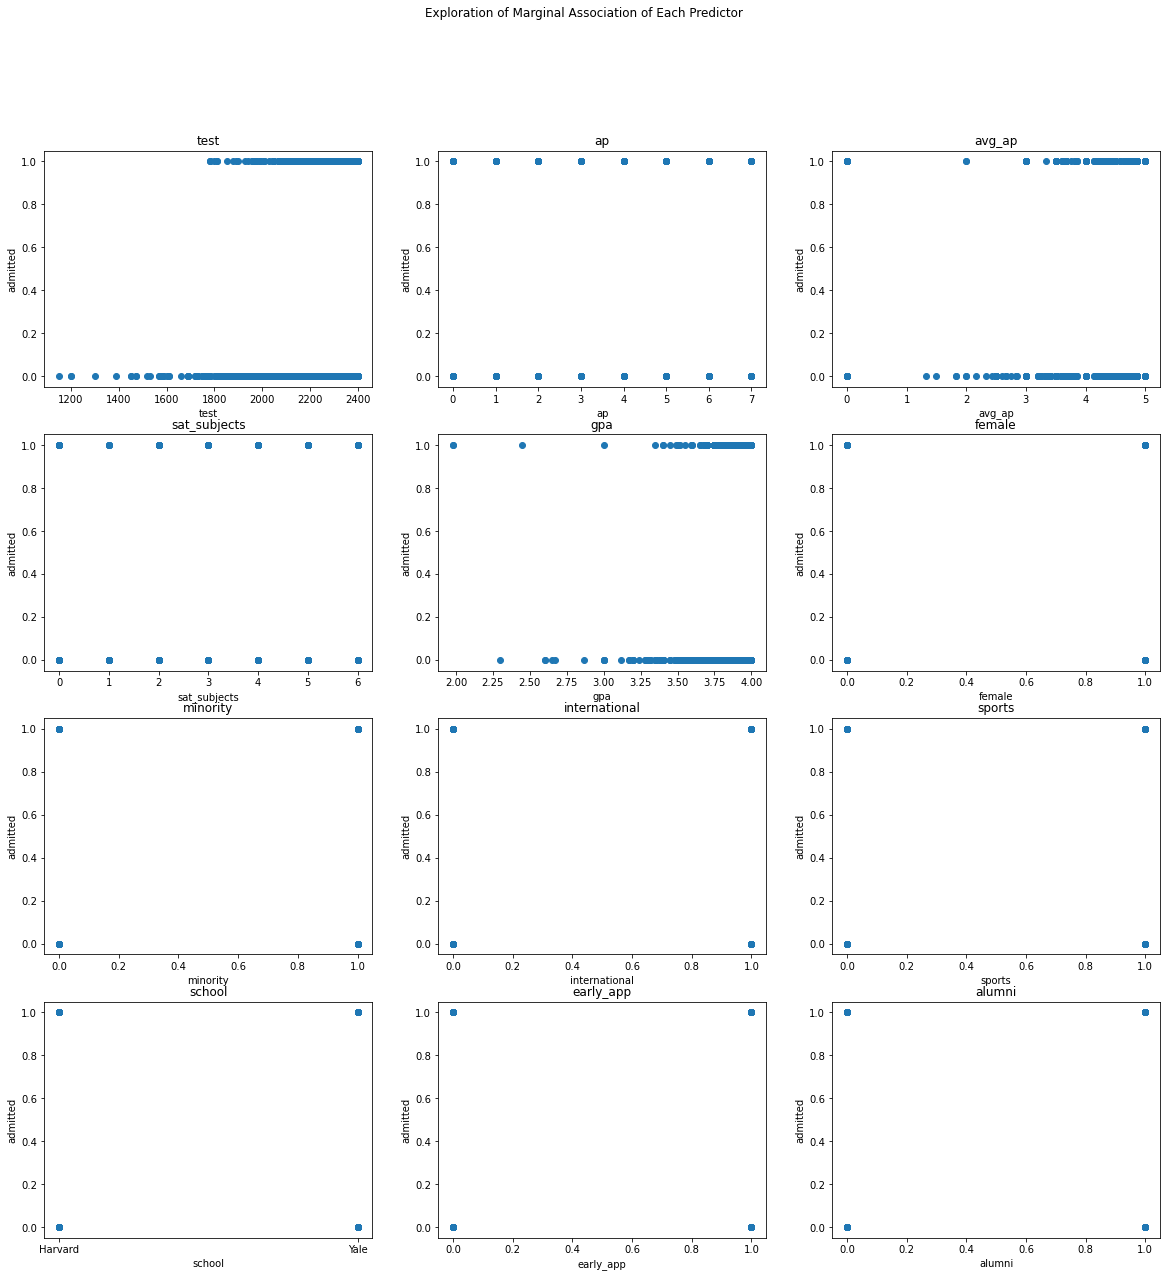

In [5]:
# your code here
college['harvard'] = np.where(college['school']== 'Harvard', 1, 0)
college_train['harvard'] = np.where(college_train['school']== 'Harvard', 1, 0)
college_test['harvard'] = np.where(college_test['school']== 'Harvard', 1, 0)

fig, axes = plt.subplots(4, 3, figsize=(20,20))
fig.suptitle('Exploration of Marginal Association of Each Predictor')
predictors = [
    "test", "ap", "avg_ap", "sat_subjects", 
    "gpa", "female", "minority", "international",
    "sports", "school", "early_app", "alumni",
]

for pred, ax in zip(predictors, axes.flatten()):
    ax.scatter(college_train[pred], college_train['admitted'])
    ax.set_title(pred)
    ax.set_xlabel(pred)
    ax.set_ylabel('admitted')


<div class='exercise-r'>

**1.3** Based on the visuals above, which predictor seems to have the most potential for predicting `admitted`? Why do you think this it the best potential single predictor?
    
</div>

We believe that test is the best predictor as the scatterplot appears to show grouping that shows that lower test scores lead to no admission.

<div class='exercise-r'>
    
**1.4** Fit a logistic regression to predict `admitted` from `harvard` (call it `logit1_4`).  Interpret the coefficient estimates: which college is estimated to be easier to get into?  What are the estimated probabilities of getting into each school?
    
</div>

In [6]:
# your code here
logit1_4 = LogisticRegression(penalty='none', max_iter = 1000)

#Fit the model
logit1_4.fit(college_train[['harvard']], college_train['admitted'])

# Get the coefficient estimates
print("Logistic Regression Estimated Beta 0: {:.4f}".format(logit1_4.intercept_[0]))
print("Logistic Regression Estimated Beta 1: {:.4f}".format(logit1_4.coef_[0][0]))   

print("Probablity of Getting into Yale: {:.4f}%".format(logit1_4.predict_proba([[0]])[0][1]*100))
print("Probablity of Getting into Harvard: {:.4f}%".format(logit1_4.predict_proba([[1]])[0][1]*100))

Logistic Regression Estimated Beta 0: -1.1137
Logistic Regression Estimated Beta 1: 0.1532
Probablity of Getting into Yale: 24.7191%
Probablity of Getting into Harvard: 27.6786%


C:\Users\westo\miniconda3\envs\cs109a\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\westo\miniconda3\envs\cs109a\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


**INTERPRETATION:**

Harvard is easier to get into because it has a higher probability of admitting a student while Yale has a lower probability.

<div class='exercise-r'>

**1.5** Create a contingency table between `admitted` and `harvard`.  Use this table to calculate and confirm the coefficient estimates in the `logit1_4` model (both the intercept and slope).

</div>

In [7]:
# your code here
# Create a contingency table between admitted and harvard.
confusion_matrix = pd.crosstab(
    college_train['admitted'], 
    college_train['harvard'], 
    rownames=['Admitted'], 
    colnames=['Harvard'],
)
display(confusion_matrix)

# Use this table to calculate and confirm the coefficient estimates in the logit1_4 model (both the intercept and slope).
num_0 = confusion_matrix[0][1]/(confusion_matrix[0][0]+confusion_matrix[0][1])
den_0 = 1 - num_0
b0 = np.log(num_0/den_0)

num_1 = confusion_matrix[1][1]/(confusion_matrix[1][0]+confusion_matrix[1][1])
den_1 = 1 - num_1
b1 = np.log(num_1/den_1) - b0

print("Beta 0: {:.4f}".format(b0))
print("Beta 1: {:.4f}".format(b1))

Harvard,0,1
Admitted,,
0,536,567
1,176,217


Beta 0: -1.1137
Beta 1: 0.1532


<div class='exercise-r'>

**1.6** Compare the estimated probabilities of being admitted into the schools to the overall acceptance rate (as seen [here](https://www.ivycoach.com/2023-ivy-league-admissions-statistics/)).  Why may what you've observed in this comparison be the case?
    
</div>

The estimated probability for Harvard was 28.7% and the estimated probability for Yale was 25%. This is higher than the actual observed probabilities for admission into Harvard and Yale. This may be because our data-set is not a representative sample of the overall population. There also could be other predictors that we have not accounted for.

---

<a id="part2"></a>

## <div class='exercise'>Question 2: Interpretable modeling [18 pts]</div>

[Return to contents](#contents)

**2.1** Fit a logistic regression model to predict `admitted` from `test` alone (call it `logit2_1`).  Print out the coefficient estimates (remember to always print both intercept and slope coefficients) along with the classification accuracies for this model (on both train and test data). 

**2.2** What is the estimated probability of an applicant being admitted with an *average* `test` score of 2250?  What about if they had a perfect test score of 2400?  What test score would be needed to have a 50-50 chance (i.e. 0.5 probability) of being admitted?

**2.3**  Fit a logistic regression model to predict `admitted` from `test` and `avg_ap` (call it `logit2_3`).  Print out the coefficient estimates along with the classification accuracies for this model (on both train and test data). 

**2.4** Interpret the coefficient estimates for both predictors in `logit2_3` and compare the coefficient estimate for `test` to the one from `logit2_1`.  Why has this estimate changed?

**HINT:** You may want to inspect the relationship between `test` and `avg_ap` to help get a better sense for what might be happening here.

**2.5** Interpret and compare the classification accuracies for the two models, `logit2_1` and `logit2_3`.  Explain why these accuracies are the same or different, and what about the data makes these accuracies so similar or different.


<a id="part2solutions"></a>

## Question 2: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**2.1** Fit a logistic regression model to predict `admitted` from `test` alone (call it `logit2_1`).  Print out the coefficient estimates (remember to always print both intercept and slope coefficients) along with the classification accuracies for this model (on both train and test data).
    
</div>

In [8]:
# your code here
logit2_1 = LogisticRegression(penalty='none', max_iter = 1000)

#Fit the model
logit2_1.fit(college_train[['test']], college_train['admitted'])

# Get the coefficient estimates
print("Logistic Regression Estimated Beta 0: {:.4f}".format(logit2_1.intercept_[0]))
print("Logistic Regression Estimated Beta 1: {:.4f}".format(logit2_1.coef_[0][0]))   

# Score model
train_score2_1 = logit2_1.score(college_train[['test']], college_train['admitted'])
test_score2_1 = logit2_1.score(college_test[['test']], college_test['admitted'])

# Print scores
print("Training Set Accuracy: {:.4f}%".format(train_score2_1*100))
print("Testing Set Accuracy: {:.4f}%\n".format(test_score2_1*100))

Logistic Regression Estimated Beta 0: -9.4136
Logistic Regression Estimated Beta 1: 0.0038
Training Set Accuracy: 73.7299%
Testing Set Accuracy: 70.1333%



<div class='exercise-r'>

**2.2** What is the estimated probability of an applicant being admitted with an *average* `test` score of 2250?  What about if they had a perfect test score of 2400?  What test score would be needed to have a 50-50 chance (i.e. 0.5 probability) of being admitted?
    
</div>

In [9]:
# your code here
print("Probablity of Admission with Score of 2250: {:.4f}%".format(logit2_1.predict_proba([[2250]])[0][1]*100))
print("Probablity of Admission with Score of 2400: {:.4f}%".format(logit2_1.predict_proba([[2400]])[0][1]*100))

test_score = -logit2_1.intercept_[0]/logit2_1.coef_[0][0]

print("Test score for a 50% chance of admission would be: {:.4f}".format(test_score))

Probablity of Admission with Score of 2250: 29.2949%
Probablity of Admission with Score of 2400: 42.2561%
Test score for a 50% chance of admission would be: 2482.3446


C:\Users\westo\miniconda3\envs\cs109a\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\westo\miniconda3\envs\cs109a\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Increasing test scores lead to a higher probability of being admitted. A test score of 2482 would be necessary to have a 50% chance of admission. However, this exceeds the bounds of potential scores.

<div class='exercise-r'>

**2.3** Fit a logistic regression model to predict `admitted` from `test` and `avg_ap` (call it `logit2_3`).  Print out the coefficient estimates along with the classification accuracies for this model (on both train and test data).
    
</div>

In [10]:
# your code here
logit2_3 = LogisticRegression(penalty='none', max_iter = 1000)

#Fit the model
logit2_3.fit(college_train[['test', 'avg_ap']], college_train['admitted'])

# Get the coefficient estimates
print("Logistic Regression Estimated Beta 0: {:.4f}".format(logit2_3.intercept_[0]))
print("Logistic Regression Estimated Beta 1: {:.4f}".format(logit2_3.coef_[0][0])) 
print("Logistic Regression Estimated Beta 2: {:.4f}".format(logit2_3.coef_[0][1])) 

# Score model
train_score2_3 = logit2_3.score(college_train[['test', 'avg_ap']], college_train['admitted'])
test_score2_3 = logit2_3.score(college_test[['test', 'avg_ap']], college_test['admitted'])

# Print scores
print("Training Set Accuracy: {:.4f}%".format(train_score2_3*100))
print("Testing Set Accuracy: {:.4f}%\n".format(test_score2_3*100))

Logistic Regression Estimated Beta 0: -0.0188
Logistic Regression Estimated Beta 1: -0.0005
Logistic Regression Estimated Beta 2: 0.0533
Training Set Accuracy: 73.7299%
Testing Set Accuracy: 70.1333%



<div class='exercise-r'>

**2.4** Interpret the coefficient estimates for both predictors in `logit2_3` and compare the coefficient estimate for `test` to the one from `logit2_1`.  Why has this estimate changed?

**HINT:** You may want to inspect the relationship between `test` and `avg_ap` to help get a better sense for what might be happening here.

</div>

Text(0, 0.5, 'Average AP Score')

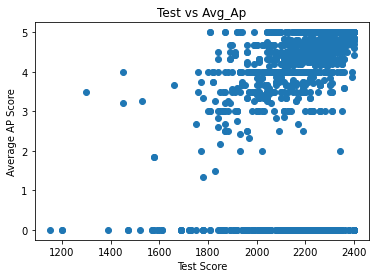

In [11]:
# your code here
plt.scatter(college_train['test'], college_train['avg_ap'])
plt.title("Test vs Avg_Ap")
plt.xlabel("Test Score")
plt.ylabel("Average AP Score")

**INTERPRETATION:**

The coefficient for test in 2_1 was 0.003 and now in 2_3 it is -0.0005. The coefficient for test has become negative since 2_3 also takes avg_ap as a predictor. Test and Avg_ap are positively correlated, so the logistic regression model is compensating by making test negative so that it does not over-predict the probability of admission. The coefficient for avg_ap is positive because an increase in the avg_ap score leads to a higher probability of admission in general.

<div class='exercise-r'>

**2.5** Interpret and compare the classification accuracies for the two models, `logit2_1` and `logit2_3`.  Explain why these accuracies are the same or different, and what about the data makes these accuracies so similar or different.

</div>

The accuracies are the same for logit2_1 and logit 2_3. This is because the predictors have collinearity, so adding an additional predictor avg_ap does nothing to increase the predictive power of the model.

---

<a id="part3"></a>

## <div class='exercise'>Question 3: Harvard and Yale? [30 pts]</div>

[Return to contents](#contents)

**3.1** Fit a logistic regression model (call it `logit3_1`) to predict `admitted` from 7 predictors: `["harvard", "test", "ap", "avg_ap", "gpa", "female", "minority"]`.  Output and interpret the coefficient estimates for the binary predictors in this model.

**HINT:** If you have convergence warnings, increasing the maximum number of iterations will likely solve this issue.

**3.2** Fit a logistic regression model (call it `logit3_2`) to predict `admitted` from 3 predictors: `["harvard", "test", "ap"]` along with the 2 interaction terms: `harvard` with `test` and `harvard` with `ap`. Name the columns for these interaction terms something sensible.  Print out the coefficient estimates for this model.

**3.3** Simplify and write out mathematically the above model from Question 3.2 for 2 applicants: (1) someone who is applying to Harvard and for (2) someone who is applying to Yale (keep `test` and `ap` as the unknown $X$s).  The basic framework given to you below may be helpful:

$$ \ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) = \beta_0 + \beta_1 X_1 + \dots + \beta_p X_p $$

**NOTE:** All of your mathematical statements should be written out in your markdown cells using $\LaTeX$.

**3.4** Determine two classification boundaries mathematically for the model in the previous part (using the estimated coefficients): What range of values of `test` as a function of `ap` would an applicant be predicted to have a better than 50% chance (i.e. 0.5 probability) of being admitted into the college they applied (each college is associated with a different function)? If a student scored a perfect 2400 on `test`, what is the range of AP tests they should take in order to have a better than 50% chance of being admitted into Harvard?

**3.5** Create two separate scatterplots (one for Harvard applicants and one for Yale applicants) with the predictor `test` on the y-axis and `ap` on the x-axis where `admitted` is color-coded and the marker denotes train vs. test data.  Then add the appropriate classification boundary from the previous part.  Compare these two plots (including both the location of the boundaries and where the points lie around these boundaries).

**NOTE:** As always, please be certain (a) your plot is titled, (b) everything is clearly labeled, and (c) the plot itself is formatted in a manner that makes it easy to read and interpret. It will likely take some careful work here to generate plots with data points that are clear and easy to see.

**3.6** Fit a logistic regression model (call it `logit3_6`) to predict `admitted` from 4 predictors: `["harvard", "test", "female", "minority"]` along with 2 interaction terms: `harvard` with `female` and `harvard` with `minority`.  Print out the coefficient estimates for this model.

**3.7** Interpret the coefficients associated with `female` and `minority` (the two main effects AND the two interaction terms).

**3.8** Based on this sample, how does it appear that Harvard and Yale compare in admitting these groups?  Why would it be wrong to take this interpretation as truth?

<a id="part3solutions"></a>

## Question 3: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**3.1** Fit a logistic regression model (call it `logit3_1`) to predict `admitted` from 7 predictors: `["harvard", "test", "ap", "avg_ap", "gpa", "female", "minority"]`.  Output and interpret the coefficient estimates for the binary predictors in this model.

**HINT:** If you have convergence warnings, increasing the maximum number of iterations will likely solve this issue.
    
</div>

In [12]:
# your code here
logit3_1 = LogisticRegression(penalty='none', max_iter = 1000, random_state=5)

#Fit the model
logit3_1.fit(college_train[["harvard", "test", "ap", "avg_ap", "gpa", "female", "minority"]], college_train['admitted'])

# Get the coefficient estimates
print("Logistic Regression Estimated Beta 0: {:.4f}".format(logit3_1.intercept_[0]))
print("Logistic Regression Estimated Beta 1 (harvard): {:.4f}".format(logit3_1.coef_[0][0])) 
print("Logistic Regression Estimated Beta 6 (female): {:.4f}".format(logit3_1.coef_[0][5])) 
print("Logistic Regression Estimated Beta 7 (minority): {:.4f}".format(logit3_1.coef_[0][6])) 

Logistic Regression Estimated Beta 0: -0.7304
Logistic Regression Estimated Beta 1 (harvard): 0.0600
Logistic Regression Estimated Beta 6 (female): 0.0477
Logistic Regression Estimated Beta 7 (minority): 0.6371


**INTERPRETATION:**

The natural log of the odds of being admitted increases when a person applies to Harvard. The natural log of the odds of being admitted decreases when a female applies to university. The natural log of the odds of being admitted increases when a person who is a minority applies to university. Out of all predictors, minority has the strongest effect on the odds of getting into university.

<div class='exercise-r'>

**3.2** Fit a logistic regression model (call it `logit3_2`) to predict `admitted` from 3 predictors: `["harvard", "test", "ap"]` along with the 2 interaction terms: `harvard` with `test` and `harvard` with `ap`. Name the columns for these interaction terms something sensible.  Print out the coefficient estimates for this model.

</div>

In [13]:
# your code here
logit3_2 = LogisticRegression(penalty='none', max_iter = 1000, random_state=5)

#Interaction terms
predictors_htest = ["harvard", "test"]
predictors_hap = ["harvard", "ap"]
for college in [college_train, college_test]:
    college["_".join(predictors_htest)] = college[predictors_htest[0]] * college[predictors_htest[1]]
    college["_".join(predictors_hap)] = college[predictors_hap[0]] * college[predictors_hap[1]]
    
#Fit the model
predictors = ["harvard", "test", "ap", "harvard_test", "harvard_ap"]
logit3_2.fit(college_train[predictors], college_train['admitted'])

# Get the coefficient estimates
print("Logistic Regression Estimated Beta 0: {:.4f}".format(logit3_2.intercept_[0]))

for i, name in enumerate(logit3_2.coef_[0]):
    print("Logistic Regression Estimated Beta {} ({}): {:.4f}".format(i+1, predictors[i], logit3_2.coef_[0][i])) 

Logistic Regression Estimated Beta 0: -7.1344
Logistic Regression Estimated Beta 1 (harvard): -4.4410
Logistic Regression Estimated Beta 2 (test): 0.0027
Logistic Regression Estimated Beta 3 (ap): 0.0240
Logistic Regression Estimated Beta 4 (harvard_test): 0.0022
Logistic Regression Estimated Beta 5 (harvard_ap): -0.1101


<div class='exercise-r'>

**3.3** Simplify and write out mathematically the above model from Question 3.2 for 2 applicants: (1) someone who is applying to Harvard and for (2) someone who is applying to Yale (keep `test` and `ap` as the unknown $X$s).  The basic framework given to you below may be helpful:

$$ \ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) = \beta_0 + \beta_1 X_1 + \dots + \beta_p X_p $$
    
**NOTE:** All of your mathematical statements should be written out in your markdown cells using $\LaTeX$.

</div>

$HarvardOdds= (B_0 + B_1) + (B_2 + B_4)Test + (B_3+B_5)AP$

$YaleOdds= B_0 + B_2Test + B_3AP$

<div class='exercise-r'>

**3.4** Determine two classification boundaries mathematically for the model in the previous part (using the estimated coefficients): What range of values of `test` as a function of `ap` would an applicant be predicted to have a better than 50% chance (i.e. 0.5 probability) of being admitted into the college they applied (each college is associated with a different function)? If a student scored a perfect 2400 on `test`, what is the range of AP tests they should take in order to have a better than 50% chance of being admitted into Harvard?

</div>

$HarvardTest= \frac{(B_0 + B_1) + (B_3 + B_5)AP} {-B_2-B_4}$

$2400 = -40.4858 (-11.5754 - 0.0861 AP)$

$AP \geq 554.06$

$ ------ $

$YaleTest= \frac{B_0 + B_3AP} {-B_2}$

$2400 = -370.37 (-7.1344 - 0.024 x)$

$AP \geq -27.2667$

<div class='exercise-r'>

**3.5** Create two separate scatterplots (one for Harvard applicants and one for Yale applicants) with the predictor `test` on the y-axis and `ap` on the x-axis where `admitted` is color-coded and the marker denotes train vs. test data.  Then add the appropriate classification boundary from the previous part.  Compare these two plots (including both the location of the boundaries and where the points lie around these boundaries).

**NOTE:** As always, please be certain (a) your plot is titled, (b) everything is clearly labeled, and (c) the plot itself is formatted in a manner that makes it easy to read and interpret. It will likely take some careful work here to generate plots with data points that are clear and easy to see.
    
</div>

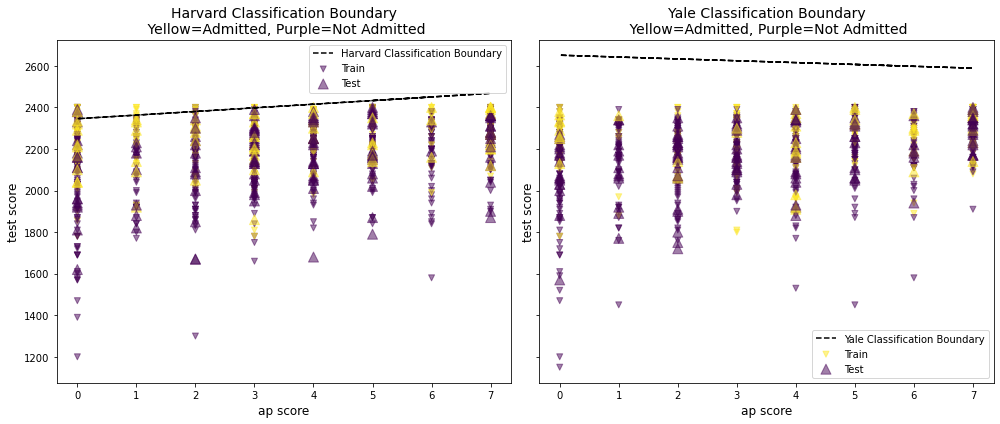

In [20]:
# your code here
y = college_train['test']
x = college_train[['ap']]

x_harv= college_train[college_train['harvard']==1][['ap']]
c_harv= college_train[college_train['harvard']==1]['admitted']
y_harvp= college_train[college_train['harvard']==1]['test']

x_harvt= college_test[college_test['harvard']==1][['ap']]
c_harvt= college_test[college_test['harvard']==1]['admitted']
y_harvpt= college_test[college_test['harvard']==1]['test']

x_yale= college_train[college_train['harvard']==0][['ap']]
c_yale= college_train[college_train['harvard']==0]['admitted']
y_yalep= college_train[college_train['harvard']==0]['test']

x_yalet= college_test[college_test['harvard']==0][['ap']]
c_yalet= college_test[college_test['harvard']==0]['admitted']
y_yalept= college_test[college_test['harvard']==0]['test']

b0= logit3_2.intercept_[0]
b1= logit3_2.coef_[0][0]
b2= logit3_2.coef_[0][1]
b3= logit3_2.coef_[0][2]
b4= logit3_2.coef_[0][3]
b5= logit3_2.coef_[0][4]

y_harv= ((b0+b1)+(b3+b5)*x)/(-b2-b4)
y_yale= (b0+b3*x)/(-b2)

f, axes = plt.subplots(1,2, figsize=(14,6), sharey='row')

axes[0].plot(x, y_harv, 'k--', label="Harvard Classification Boundary")
axes[0].scatter(x_harv, y_harvp, marker='v', c=c_harv, label="Train", alpha = 0.5)
axes[0].scatter(x_harvt, y_harvpt, marker='^', c=c_harvt, label="Test", alpha = 0.5, s=100)
axes[0].legend()
axes[0].set_title(
    'Harvard Classification Boundary\n Yellow=Admitted, Purple=Not Admitted',
    fontsize=14,
)
axes[0].set_ylabel('test score', fontsize=12)
axes[0].set_xlabel('ap score', fontsize=12)

axes[1].plot(x, y_yale, 'k--', label="Yale Classification Boundary")
axes[1].scatter(x_yale, y_yalep, marker='v', c=c_yale, label="Train", alpha = 0.5)
axes[1].scatter(x_yalet, y_yalept, marker='^', c=c_yalet, label="Test", alpha = 0.5, s=100)
axes[1].legend()
axes[1].set_title(
    'Yale Classification Boundary\n Yellow=Admitted, Purple=Not Admitted',
    fontsize=14,
)
axes[1].set_ylabel('test score', fontsize=12)
axes[1].set_xlabel('ap score', fontsize=12)


plt.tight_layout()
plt.show()


**INTERPRETATION:**

**Looking at this graph, the classification error is high for our logistic regression model. The boundary lines that we derived for the probability of being admitted is consistently higher than the actual admitted data for Harvard and Yale. This means that the logistic regression we made consistently under-predicts the probability of being admitted and has a high classification error.**

<div class='exercise-r'>

**3.6** Fit a logistic regression model (call it `logit3_6`) to predict `admitted` from 4 predictors: `["harvard", "test", "female", "minority"]` along with 2 interaction terms: `harvard` with `female` and `harvard` with `minority`.  Print out the coefficient estimates for this model.
    
</div>

In [18]:
# your code here
logit3_6 = LogisticRegression(penalty='none', max_iter = 1000, random_state=5)

predictors = ['harvard', 'test', 'female', 'minority']
x_train= college_train[predictors]
x_test= college_test[predictors]

predictors_hfem = ["harvard", "female"]
predictors_hmin = ["harvard", "minority"]
for college in [college_train, college_test]:
    college["_".join(predictors_hfem)] = college[predictors_hfem[0]] * college[predictors_hfem[1]]
    college["_".join(predictors_hmin)] = college[predictors_hmin[0]] * college[predictors_hmin[1]]
    
#Fit the model
predictors = ["harvard", "test", "female", "minority", "harvard_female", "harvard_minority"]
logit3_6.fit(college_train[predictors], college_train['admitted'])

# Get the coefficient estimates
print("Logistic Regression Estimated Beta 0: {:.4f}".format(logit3_6.intercept_[0]))

for i, name in enumerate(logit3_6.coef_[0]):
    print("Logistic Regression Estimated Beta {} ({}): {:.4f}".format(i+1, predictors[i], logit3_6.coef_[0][i]))

Logistic Regression Estimated Beta 0: -10.6425
Logistic Regression Estimated Beta 1 (harvard): 0.3896
Logistic Regression Estimated Beta 2 (test): 0.0042
Logistic Regression Estimated Beta 3 (female): 0.0211
Logistic Regression Estimated Beta 4 (minority): 1.4366
Logistic Regression Estimated Beta 5 (harvard_female): 0.0731
Logistic Regression Estimated Beta 6 (harvard_minority): -1.0626


<div class='exercise-r'>

**3.7** Interpret the coefficients associated with `female` and `minority` (the two main effects AND the two interaction terms).
    
</div>

**The natural logs of the odds of a female getting into harvard increases by approimately 0.08 when the female is applying to harvard. When the female is applying to yale, the natural log of the odds of a female getting into yale increases by 0.0184. The natural log of the odds of a minority getting into harvard increases by approximately 0.37, and the natural log of the odds of a minority getting into Yale increases by 1.4378.**

<div class='exercise-r'>

**3.8** Based on this sample, how does it appear that Harvard and Yale compare in admitting these groups?  Why would it be wrong to take this interpretation as truth?

</div>

**Harvard is more likely to accept females while Yale is more likely to accept minorities compared to Harvard. It would be wrong to take this interpretation as truth because this is a logistic regression, and we may not be considering other factors that could potentially change our predicted probabilities of admission for female applicants and minority applicants.**

---

<a id="part4"></a>

## <div class='exercise'>Question 4: Building predictive models for admitted [24 pts]</div>

[Return to contents](#contents)

**4.1** You were instructed to NOT scale predictors in the prior sections above. The primary reason for this was to focus instead on the interpretability of our logistic regression coefficients. However, as we're sure you noticed, the numeric scale among our different predictors varies greatly (i.e. `test` values are in the 1,000's while others are much, much smaller). In practice, we might want to put our predictors all on a similar scale, particularly for regularized regression and/or distance-based algorithms such as $k$-NN classification. (1) Please explain why scaling under these circumstances might be important. Then, (2) actually apply standardized scaling to all of the **non-binary** predictors in our original set of 12 predictors (for both the training and test sets).

**IMPORTANT:** These scaled predictors should be used instead of the original unscaled versions of the predictors for the remainder of this problem set.

**4.2** Fit a well-tuned $k$-NN classification model with main effects of all 12 predictors in it (call it `knn_model`).  Use `ks = [1, 3, 5, 9, 15, 21, 51, 71, 101, 131, 171, 201]` and 10-fold cross-validation with classification accuracy as the scoring metric. Plot, on a single set of axes, your resulting cross-validation mean training and mean validation scores at each value $k$. Then, report your chosen $k$ and the classification accuracy on train and test for your final fitted model.

**4.3** Fit the full logistic regression model (without penalty) with main effects of all 12 predictors in it (call it `logit_full`). Print out the coefficient estimates and report the classification accuracy on train and test for this model.

**HINT:** If you have convergence warnings, increasing the maximum number of iterations will likely solve this issue.

**4.4** Fit a well-tuned Lasso-like logistic regression model from all 12 predictors in it (call it `logit_lasso`). Use `Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]` and 10-fold cross-validation with classification accuracy as the scoring metric.  Print out the coefficient estimates and report the classification accuracy on train and test for this model.

**4.5** Which predictors were deemed important in `logit_lasso`?  Which were deemed unimportant? Please remember that, as a general practice, zero-value Lasso coefficients (i.e. $\beta_i=0$) are considered "unimportant".

**4.6** Fit a well-tuned Lasso-like logistic regression model with all important predictors from `logit_lasso` and all the unique 2-way interactions between them (call it `logit_lasso_interact`).  Again use `Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]` and 10-fold cross-validation with classification accuracy as the scoring metric. Report the classification accuracy on train and test for this model.

**4.7** How many of the predictors in our `logit_lasso_interact` model were deemed important and unimportant? (Feel free to just report on the number of them found to be important and unimportant. There is no need to list them all here.)

<a id="part4solutions"></a>

## Question 4: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**4.1** You were instructed to NOT scale predictors in the prior sections above. The primary reason for this was to focus instead on the interpretability of our logistic regression coefficients. However, as we're sure you noticed, the numeric scale among our different predictors varies greatly (i.e. `test` values are in the 1,000's while others are much, much smaller). In practice, we might want to put our predictors all on a similar scale, particularly for regularized regression and/or distance-based algorithms such as $k$-NN classification. (1) Please explain why scaling under these circumstances might be important. Then, (2) actually apply standardized scaling to all of the **non-binary** predictors in our original set of 12 predictors (for both the training and test sets).

**IMPORTANT:** These scaled predictors should be used instead of the original unscaled versions of the predictors for the remainder of this problem set.

</div>

**INTERPRETATION:**

**Scaling is important because it puts all predictors on the same level playing field and helps to address issues where much larger numbers might be addressed as significantly superior or more important. It equalizes the importance of the predictors.**

In [22]:
# your code here
non_binary_predict= ["test", "ap", "avg_ap", "sat_subjects", "gpa"]
scaler= StandardScaler()
nbpredict= scaler.fit_transform(college_train[non_binary_predict])
nbpredict1= scaler.fit_transform(college_test[non_binary_predict])

college_train['test']= nbpredict[:, 0]
college_train['ap']= nbpredict[:, 1]
college_train['avg_ap']= nbpredict[:,2]
college_train['sat_subjects']= nbpredict[:,3]
college_train['gpa']= nbpredict[:, 4]

college_test['test']= nbpredict1[:, 0]
college_test['ap']= nbpredict1[:, 1]
college_test['avg_ap']= nbpredict1[:,2]
college_test['sat_subjects']= nbpredict1[:,3]
college_test['gpa']= nbpredict1[:, 4]

In [23]:
college_train.head()

,id,admitted,test,ap,avg_ap,sat_subjects,gpa,female,minority,international,sports,school,early_app,alumni,program,add_info,harvard,harvard_test,harvard_ap,harvard_female,harvard_minority
584,JTEQOV7ZCB,0,-0.620,0.670,0.398,0.881,0.108,1,0,0,0,Harvard,1,0,Mechanical Engineering,Swimming 3 years Water Polo 3 years Foreign Language Honor Society PresidentMerit award in Socia...,1,2080,5,1,0
1817,I03PV24OHY,1,0.026,1.099,-0.034,0.105,0.460,1,0,0,0,Yale,0,0,legal studies,horseback riding 5 hrs week year round marching concert jazz and orchestral ensembles 30 hrs wee...,0,0,0,0,0
1308,K42SAOUYJJ,0,-0.268,-0.616,0.456,0.105,-0.896,0,0,0,0,Yale,0,0,Film,Lacrosse Film Club Take Action Club NYU Tisch Summer Film WorkshopNational Honors Society World ...,0,0,0,0,0
1336,LODYYSRTYZ,0,-0.385,1.099,-0.230,0.105,0.610,1,0,0,0,Yale,1,0,Biological Sciences,Varsity Orchestra Music Librarian 10 11 12 Violin Player Girl Scouts 10 year Member sold over 65...,0,0,0,0,0
3,OC717EAKXN,1,1.261,0.670,0.751,1.656,0.610,1,0,0,0,Harvard,0,0,Mathematics,NaN,1,2400,5,1,0


<div class='exercise-r'>

**4.2** Fit a well-tuned $k$-NN classification model with main effects of all 12 predictors in it (call it `knn_model`).  Use `ks = [1, 3, 5, 9, 15, 21, 51, 71, 101, 131, 171, 201]` and 10-fold cross-validation with classification accuracy as the scoring metric. Plot, on a single set of axes, your resulting cross-validation mean training and mean validation scores at each value $k$. Then, report your chosen $k$ and the classification accuracy on train and test for your final fitted model.
    
</div>

C:\Users\westo\miniconda3\envs\cs109a\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\westo\miniconda3\envs\cs109a\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\westo\miniconda3\envs\cs109a\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\westo\miniconda3\envs\cs109a\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\westo\miniconda3\envs\cs109a\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Us

MSE Values:  {1: 0.6731140939597315, 3: 0.700586129753915, 5: 0.7239642058165547, 9: 0.7292751677852348, 15: 0.7353109619686801, 21: 0.7386442953020134, 51: 0.7373020134228188, 71: 0.7373020134228188, 101: 0.7373020134228188, 131: 0.7373020134228188, 171: 0.7373020134228188, 201: 0.7373020134228188}

The best k is  21


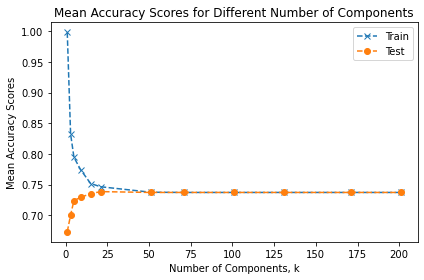

Training Set Accuracy: 74.4652%
Testing Set Accuracy: 71.2000%


C:\Users\westo\miniconda3\envs\cs109a\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\westo\miniconda3\envs\cs109a\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [32]:
np.random.seed(121) # Do not delete or modify this line of code

# your code here
ks = [1, 3, 5, 9, 15, 21, 51, 71, 101, 131, 171, 201]
predictors = [
    "test", "ap", "avg_ap", "sat_subjects", 
    "gpa", "female", "minority", "international",
    "sports", "harvard", "early_app", "alumni",
]

X_train = college_train[predictors]
y_train = college_train['admitted']

X_test = college_test[predictors]
y_test = college_test['admitted']

mse_vals_train = {}
mse_vals_test = {}

for k in ks:
    knn_model = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    mse_score = cross_validate(knn_model, X_train, y_train, cv=10, scoring="accuracy", return_train_score=True)
    mse_vals_train[k] = np.mean(mse_score['train_score'])
    mse_vals_test[k] = np.mean(mse_score['test_score'])
    
print ("MSE Values: ", mse_vals_test)
best_k = max(mse_vals_test, key=mse_vals_test.get)
print ("\nThe best k is ", best_k)

plt.plot(mse_vals_train.keys(), mse_vals_train.values(), "x--", label="Train")
plt.plot(mse_vals_test.keys(), mse_vals_test.values(), "o--", label="Test")
plt.title("Mean Accuracy Scores for Different Number of Components")
plt.xlabel("Number of Components, k")
plt.ylabel("Mean Accuracy Scores")
plt.legend()
plt.tight_layout()
plt.show()

#Training
knn_model = KNeighborsClassifier(n_neighbors=best_k).fit(X_train, y_train)

#Predict
y_pred_train = knn_model.predict(X_train)
y_pred_test = knn_model.predict(X_test)

#Perfromance Evaluation
train_score = accuracy_score(y_train, y_pred_train)*100
test_score = accuracy_score(y_test, y_pred_test)*100

print("Training Set Accuracy: {:.4f}%".format(train_score))
print("Testing Set Accuracy: {:.4f}%".format(test_score))

<div class='exercise-r'>

**4.3** Fit the full logistic regression model (without penalty) with main effects of all 12 predictors in it (call it `logit_full`). Print out the coefficient estimates and report the classification accuracy on train and test for this model.

**HINT:** If you have convergence warnings, increasing the maximum number of iterations will likely solve this issue.
    
</div>

In [34]:
# your code here
logit_full = LogisticRegression(penalty='none', max_iter = 1000)

predictors = [
    "test", "ap", "avg_ap", "sat_subjects", 
    "gpa", "female", "minority", "international",
    "sports", "harvard", "early_app", "alumni",
]
X_train = college_train[predictors]
y_train = college_train['admitted']

X_test = college_test[predictors]
y_test = college_test['admitted']
    
#Fit the model
logit_full.fit(X_train, y_train)

# Get the coefficient estimates
print("Logistic Regression Estimated Beta 0: {:.4f}".format(logit_full.intercept_[0]))

for i, name in enumerate(logit_full.coef_[0]):
    print("Logistic Regression Estimated Beta {} ({}): {:.4f}".format(i+1, predictors[i], logit_full.coef_[0][i]))

#Predict
y_pred_train = logit_full.predict(X_train)
y_pred_test = logit_full.predict(X_test)

#Perfromance Evaluation
train_score = accuracy_score(y_train, y_pred_train)*100
test_score = accuracy_score(y_test, y_pred_test)*100

print("Training Set Accuracy: {:.4f}%".format(train_score))
print("Testing Set Accuracy: {:.4f}%".format(test_score))


Logistic Regression Estimated Beta 0: -1.7090
Logistic Regression Estimated Beta 1 (test): 0.7838
Logistic Regression Estimated Beta 2 (ap): -0.1403
Logistic Regression Estimated Beta 3 (avg_ap): 0.0975
Logistic Regression Estimated Beta 4 (sat_subjects): -0.0952
Logistic Regression Estimated Beta 5 (gpa): 0.1056
Logistic Regression Estimated Beta 6 (female): 0.0518
Logistic Regression Estimated Beta 7 (minority): 0.9165
Logistic Regression Estimated Beta 8 (international): 0.4500
Logistic Regression Estimated Beta 9 (sports): 1.2334
Logistic Regression Estimated Beta 10 (harvard): 0.2581
Logistic Regression Estimated Beta 11 (early_app): 0.3737
Logistic Regression Estimated Beta 12 (alumni): 0.6629
Training Set Accuracy: 74.5321%
Testing Set Accuracy: 70.9333%


<div class='exercise-r'>

**4.4** Fit a well-tuned Lasso-like logistic regression model from all 12 predictors in it (call it `logit_lasso`). Use `Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]` and 10-fold cross-validation with classification accuracy as the scoring metric.  Print out the coefficient estimates and report the classification accuracy on train and test for this model.

</div>

In [46]:
# your code here
# Fit cv logistic regression model to predictors
Cs = [1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3,1e4]
cv = 10
penalty = 'l1'
solver = 'liblinear'

logit_lasso = LogisticRegressionCV(
    Cs=Cs, cv=cv, penalty=penalty, solver='liblinear'
).fit(X_train, y_train)

# Get the coefficient estimates
print("Logistic Regression Estimated Beta 0: {:.4f}".format(logit_lasso.intercept_[0]))

for i, name in enumerate(logit_lasso.coef_[0]):
    print("Logistic Regression Estimated Beta {} ({}): {:.4f}".format(i+1, predictors[i], logit_lasso.coef_[0][i]))

#Predict
y_pred_train = logit_lasso.predict(X_train)
y_pred_test = logit_lasso.predict(X_test)

#Perfromance Evaluation
train_score = accuracy_score(y_train, y_pred_train)*100
test_score = accuracy_score(y_test, y_pred_test)*100

print("Training Set Accuracy: {:.4f}%".format(train_score))
print("Testing Set Accuracy: {:.4f}%".format(test_score))

Logistic Regression Estimated Beta 0: -1.7012
Logistic Regression Estimated Beta 1 (test): 0.7819
Logistic Regression Estimated Beta 2 (ap): -0.1387
Logistic Regression Estimated Beta 3 (avg_ap): 0.0952
Logistic Regression Estimated Beta 4 (sat_subjects): -0.0943
Logistic Regression Estimated Beta 5 (gpa): 0.1045
Logistic Regression Estimated Beta 6 (female): 0.0492
Logistic Regression Estimated Beta 7 (minority): 0.9120
Logistic Regression Estimated Beta 8 (international): 0.4403
Logistic Regression Estimated Beta 9 (sports): 1.2213
Logistic Regression Estimated Beta 10 (harvard): 0.2544
Logistic Regression Estimated Beta 11 (early_app): 0.3701
Logistic Regression Estimated Beta 12 (alumni): 0.6563
Training Set Accuracy: 74.5321%
Testing Set Accuracy: 70.6667%


<div class='exercise-r'>

**4.5** Which predictors were deemed important in `logit_lasso`?  Which were deemed unimportant? Please remember that, as a general practice, zero-value Lasso coefficients (i.e. $\beta_i=0$) are considered "unimportant".
 
</div>

In [50]:
# your code here
counter = 0
for i, name in enumerate(logit_lasso.coef_[0]):
    if logit_lasso.coef_[0][i] == 0:
        counter += 1
        print("Logistic Regression Estimated Beta {} ({}) is unimportant.")

if counter == 0:
    print("All features were deemed important.")


All features were deemed important.


<div class='exercise-r'>

**4.6** Fit a well-tuned Lasso-like logistic regression model with all important predictors from `logit_lasso` and all the unique 2-way interactions between them (call it `logit_lasso_interact`).  Again use `Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]` and 10-fold cross-validation with classification accuracy as the scoring metric. Report the classification accuracy on train and test for this model.

</div>

In [56]:
# your code here
# Fit cv logistic regression model to predictors
Cs = [1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3,1e4]
cv = 10
penalty = 'l1'
solver = 'liblinear'

predictors = [
    "test", "ap", "avg_ap", "sat_subjects", 
    "gpa", "female", "minority", "international",
    "sports", "harvard", "early_app", "alumni",
]

x_train= college_train[predictors]
x_test= college_test[predictors]

X_train_poly = PolynomialFeatures(degree=1, interaction_only=True, include_bias= False).fit_transform(x_train)
X_test_poly = PolynomialFeatures(degree=1, interaction_only=True, include_bias= False).fit_transform(x_test)

y_train= college_train['admitted']
y_test= college_test['admitted']


logit_lasso_interact = LogisticRegressionCV(
    Cs=Cs, cv=cv, penalty=penalty, solver='liblinear'
).fit(X_train_poly, y_train)

# Get the coefficient estimates
print("Logistic Regression Estimated Beta 0: {:.4f}".format(logit_lasso_interact.intercept_[0]))

for i, name in enumerate(logit_lasso_interact.coef_[0]):
    print("Logistic Regression Estimated Beta {} ({}): {:.4f}".format(i+1, predictors[i], logit_lasso_interact.coef_[0][i]))

#Predict
y_pred_train = logit_lasso_interact.predict(X_train_poly)
y_pred_test = logit_lasso_interact.predict(X_test_poly)

#Perfromance Evaluation
train_score = accuracy_score(y_train, y_pred_train)*100
test_score = accuracy_score(y_test, y_pred_test)*100

print("Training Set Accuracy: {:.4f}%".format(train_score))
print("Testing Set Accuracy: {:.4f}%".format(test_score))

Logistic Regression Estimated Beta 0: -1.7014
Logistic Regression Estimated Beta 1 (test): 0.7819
Logistic Regression Estimated Beta 2 (ap): -0.1388
Logistic Regression Estimated Beta 3 (avg_ap): 0.0952
Logistic Regression Estimated Beta 4 (sat_subjects): -0.0943
Logistic Regression Estimated Beta 5 (gpa): 0.1045
Logistic Regression Estimated Beta 6 (female): 0.0493
Logistic Regression Estimated Beta 7 (minority): 0.9121
Logistic Regression Estimated Beta 8 (international): 0.4403
Logistic Regression Estimated Beta 9 (sports): 1.2214
Logistic Regression Estimated Beta 10 (harvard): 0.2545
Logistic Regression Estimated Beta 11 (early_app): 0.3701
Logistic Regression Estimated Beta 12 (alumni): 0.6563
Training Set Accuracy: 74.5321%
Testing Set Accuracy: 70.6667%


<div class='exercise-r'>

**4.7** How many of the predictors in our `logit_lasso_interact` model were deemed important and unimportant? (Feel free to just report on the number of them found to be important and unimportant. There is no need to list them all here.)
    
</div>

In [57]:
# your code here
counter = 0
for i, name in enumerate(logit_lasso_interact.coef_[0]):
    if logit_lasso.coef_[0][i] == 0:
        counter += 1
        print("Logistic Regression Estimated Beta {} ({}) is unimportant.")

if counter == 0:
    print("All features were deemed important.")

All features were deemed important.


---

<a id="part5"></a>

## <div class='exercise'>Question 5: Evaluating results [12 pts]</div>

[Return to contents](#contents)

**5.1** Which of the 4 models in Question 4 performs the best based on classification accuracy?  Which performs the worst? Based on these accuracies, how do these models perform compared to your baseline "naive" model back in Question 1.1? What does this comparison to the "naive" model tell us?

**5.2** Draw the four ROC curves on the same set of axes using the test data.  How do these ROC curves compare?  Do the ROC curves support that the best model identified in Question 5.1 is better than the worst model identified in 5.1?  How do you know?

**5.3** Calculate and report AUC for all 4 models.  Do the rankings of these 4 models based on AUC match those for classification accuracy?  Why do you think this is the case?

**5.4** If you were to use one of these 4 models to present as a prediction model for the website [collegedata.com](https://www.collegedata.com/), which would you use and why?  What may be the biggest issue if this was a publicly available tool for college applicants to use to determine their chances of getting into Harvard and/or Yale?


<a id="part5solutions"></a>

## Question 5: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**5.1** Which of the 4 models in Question 4 performs the best based on classification accuracy?  Which performs the worst? Based on these accuracies, how do these models perform compared to your baseline "naive" model back in Question 1.1? What does this comparison to the "naive" model tell us?
    
</div>

In [ ]:
# your code here


**INTERPRETATION:**

**your answer here**

<div class='exercise-r'>

**5.2** Draw the four ROC curves on the same set of axes using the test data.  How do these ROC curves compare?  Do the ROC curves support that the best model identified in Question 5.1 is better than the worst model identified in 5.1?  How do you know?
    
</div>

In [ ]:
# your code here


**INTERPRETATION:**

**your answer here**

<div class='exercise-r'>

**5.3** Calculate and report AUC for all 4 models.  Do the rankings of these 4 models based on AUC match those for classification accuracy?  Why do you think this is the case?
    
</div>

In [ ]:
# your code here


**INTERPRETATION:**

**your answer here**

<div class='exercise-r'>

**5.4** If you were to use one of these 4 models to present as a prediction model for the website [collegedata.com](https://www.collegedata.com/), which would you use and why?  What may be the biggest issue if this was a publicly available tool for college applicants to use to determine their chances of getting into Harvard and/or Yale?
    
</div>

**your answer here**

#### THE END

[Return to contents](#contents)